## Mona's Demo Code 

This is just me throwing a linear regression and a regression tree at the problem, obviously not getting good predictions yet. The tree gets good if we make it very deep, but somehow the train and test error are almost exactly the same at any complexity/depth. 

Learnings:
- We probably need time-based cross-validation
- for some reason one-hot encoding our categorical features makes predictions worse

What's missing?
- Implementing this in a nice object-oriented way so we can actually run experiments and compare results, i'm working on the framework for that

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('data/raw/weather-hour.csv')

In [6]:
weather = df.iloc[:,1:].copy()

In [7]:
weather.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
weather["cnt"].describe()
# min = 1
# max = 977

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

### Preprocessing:

In [9]:
# find missing values
weather.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [10]:
weather.shape

(17379, 16)

In [13]:
X = weather.drop(columns=["casual", "registered", "cnt"])
y = weather["cnt"]

In [14]:
# feature engineering: removing date column
X = X.drop(columns=["dteday"])

In [15]:
from sklearn.model_selection import train_test_split

seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 
#To make the validation set 20% of the original data we use test size 0.25 as 0.25*0.8=0.2

### Models:

In [16]:
# fit linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# fit the model
model = LinearRegression().fit(X_train, y_train)

# make predictions on the validation set
y_train_pred = model.predict(X_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")

Train MSE: 20508.17
Test MSE: 19401.96


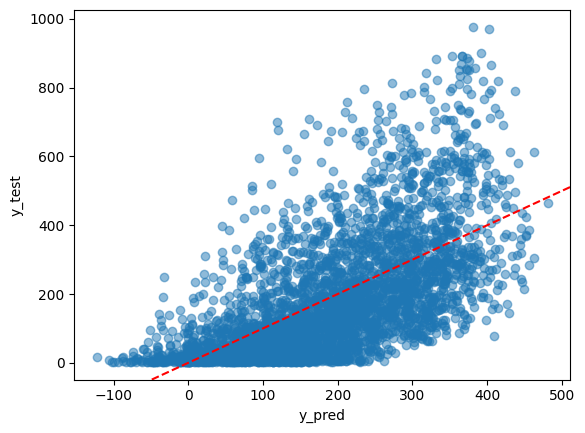

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('y_pred')
plt.ylabel('y_test')
# add the line y=x for reference
plt.axline((0, 0), slope = 1, color='red', linestyle='--') 
plt.show()

In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dt_reg = DecisionTreeRegressor(max_depth = 3, random_state=42)
dt_reg.fit(X_train, y_train)

y_train_pred_dt_reg = dt_reg.predict(X_train)
y_pred_dt_reg = dt_reg.predict(X_test)

# evaluate the model
mse_train_dt_reg = mean_squared_error(y_train, y_train_pred_dt_reg)
mse_test_dt_reg = mean_squared_error(y_test, y_pred_dt_reg)

print(f"Train MSE: {mse_train_dt_reg:.2f}")
print(f"Test MSE: {mse_test_dt_reg:.2f}")

Train MSE: 17027.51
Test MSE: 16291.66


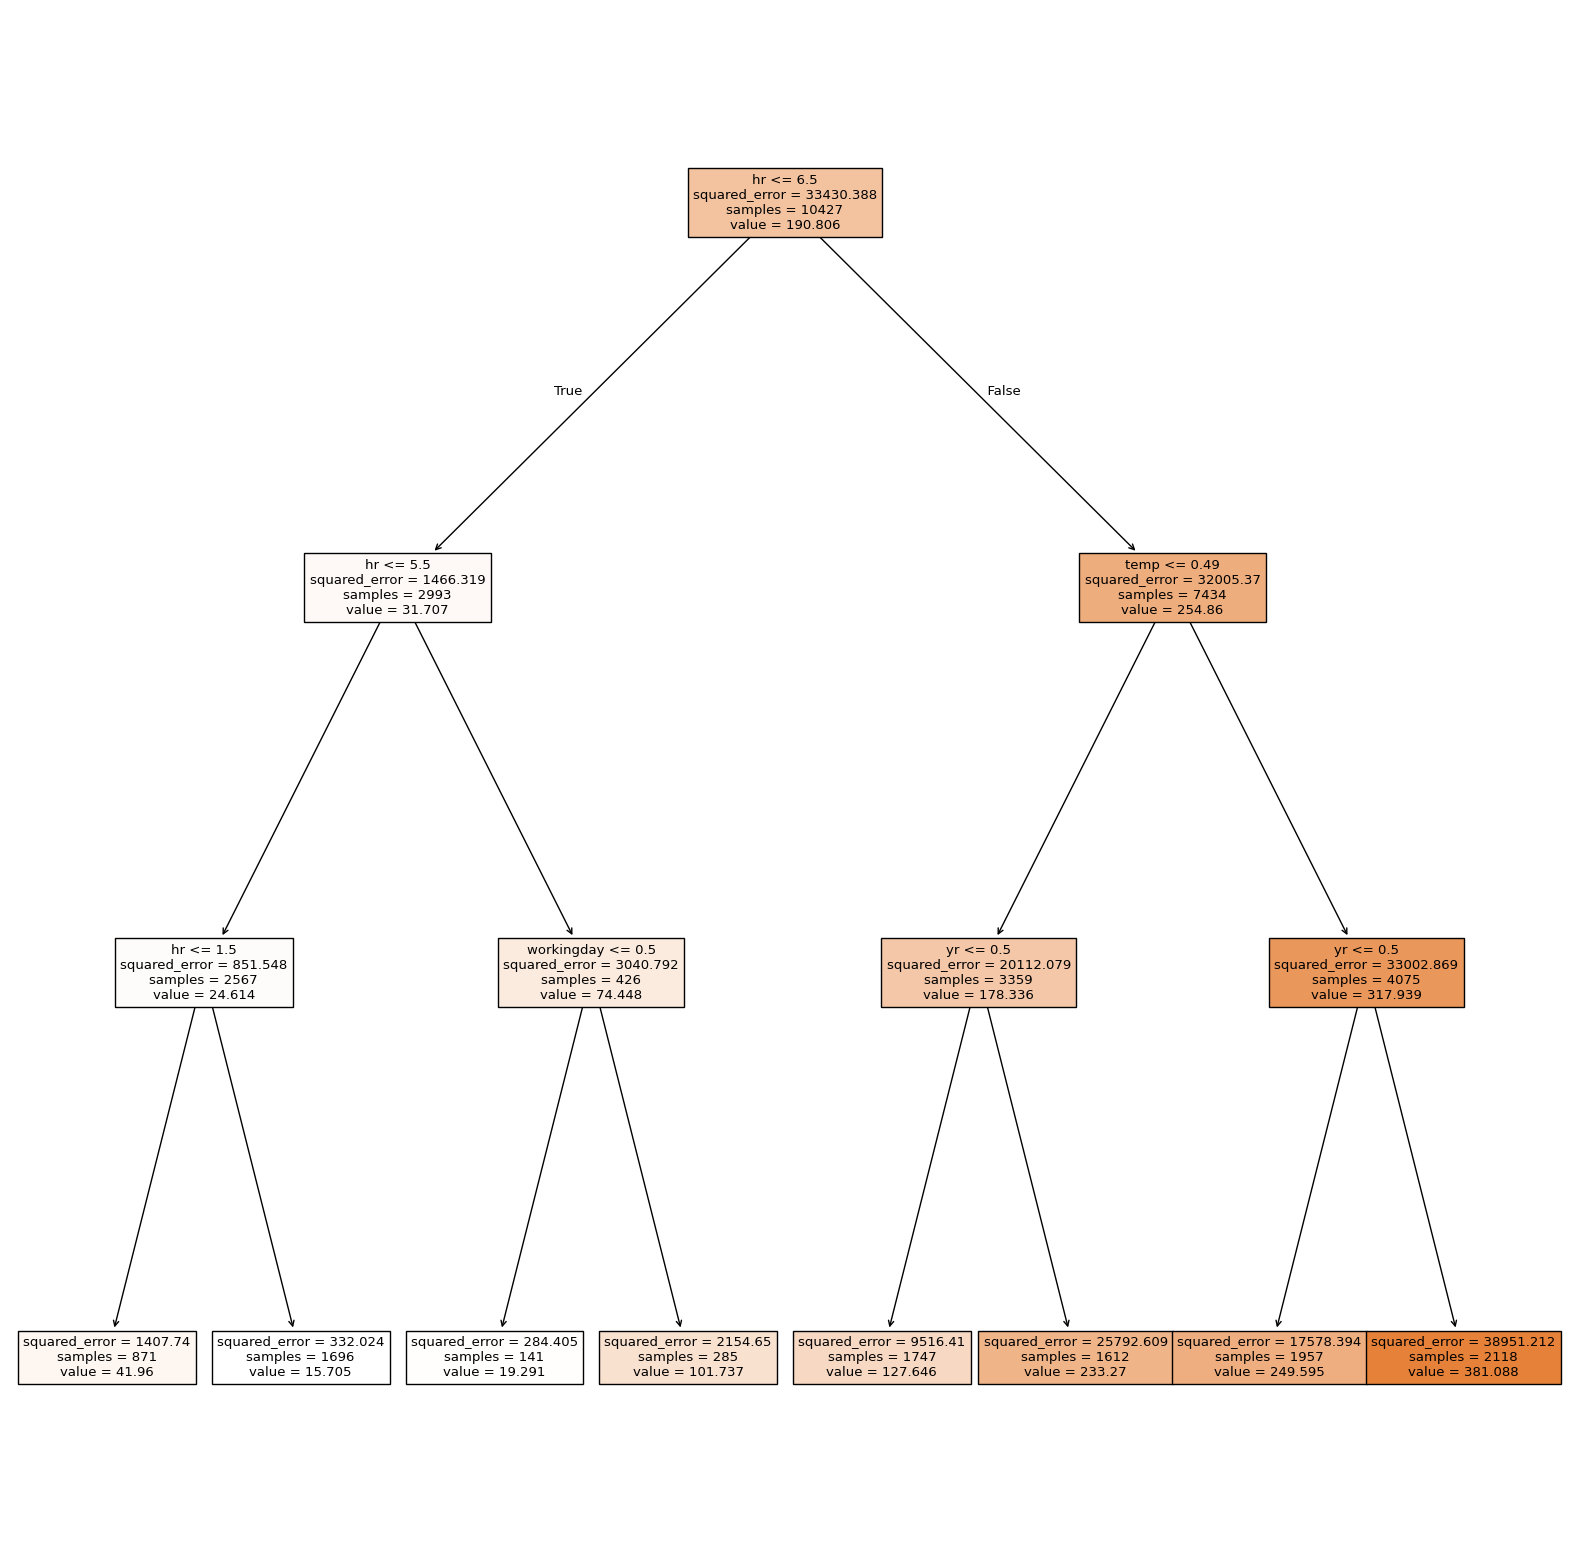

In [19]:
#Display the decision tree
plt.figure(figsize=(20,20))
plot_tree(dt_reg, feature_names = X_train.columns, filled=True)
plt.show()

In [20]:
dt_reg = DecisionTreeRegressor(max_depth = 15, random_state=42)
dt_reg.fit(X_train, y_train)

y_train_pred_dt_reg = dt_reg.predict(X_train)
y_pred_dt_reg = dt_reg.predict(X_test)

# evaluate the model
mse_train_dt_reg = mean_squared_error(y_train, y_train_pred_dt_reg)
mse_test_dt_reg = mean_squared_error(y_test, y_pred_dt_reg)

print(f"Train MSE: {mse_train_dt_reg:.2f}")
print(f"Test MSE: {mse_test_dt_reg:.2f}")

# can get very low MSE with higher depth, somehow train and test MSE scale together, tho :(
# think we might need to think of splitting test set by time

Train MSE: 317.43
Test MSE: 3620.98


### OneHot Encoding increases MSEs:

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['season', 'yr', 'weathersit']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features)
])

# Use the preprocessor to transform the data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

In [22]:
# fit the model
model = LinearRegression().fit(X_train_proc, y_train)

# make predictions on the validation set
y_train_pred = model.predict(X_train_proc)

# make predictions on the test set
y_pred = model.predict(X_test_proc)

# evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")

Train MSE: 28429.42
Test MSE: 27429.14


In [24]:
dt_reg = DecisionTreeRegressor(max_depth = 3,random_state=42)
dt_reg.fit(X_train_proc, y_train)

y_train_pred_dt_reg = dt_reg.predict(X_train_proc)
y_pred_dt_reg = dt_reg.predict(X_test_proc)

# evaluate the model
mse_train_dt_reg = mean_squared_error(y_train, y_train_pred_dt_reg)
mse_test_dt_reg = mean_squared_error(y_test, y_pred_dt_reg)

print(f"Train MSE: {mse_train_dt_reg:.2f}")
print(f"Test MSE: {mse_test_dt_reg:.2f}")

Train MSE: 33921.32
Test MSE: 33889.75


In [23]:
#Display the decision tree
plt.figure(figsize=(20,20))
plot_tree(dt_reg, feature_names = X_train.columns, filled=True)
plt.show()

KeyboardInterrupt: 